# **Install API**

In [1]:
!pip -q install  fredapi


# **Import Library**

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# **Pull Data from API**

In [3]:

# ================================================================
# 1. Pull monthly macro-economic series from FRED
# ================================================================
start_date = "1970-01-01"
end_date   = datetime.today().strftime("%Y-%m-%d")

series_codes = {
    "CPIAUCSL": "CPI",       # Consumer Price Index (all items)
    "PPIACO"  : "PPI",       # Producer Price Index (all commodities)
    "UNRATE"  : "UnempRate", # Unemployment rate
}

raw_dfs = []
for code, new_name in series_codes.items():
    s = DataReader(code, data_source="fred", start=start_date, end=end_date)
    s.columns = [new_name]
    raw_dfs.append(s)

df = pd.concat(raw_dfs, axis=1)

In [4]:
df

,CPI,PPI,UnempRate
DATE,,,
1970-01-01,37.900,36.500,3.9
1970-02-01,38.100,36.700,4.2
1970-03-01,38.300,36.700,4.4
1970-04-01,38.500,36.800,4.6
1970-05-01,38.600,36.800,4.8
...,...,...,...
2025-01-01,319.086,257.360,4.0
2025-02-01,319.775,259.529,4.1
2025-03-01,319.615,258.573,4.2


## **Set the date column**

In [5]:
# Ensure a proper DateTimeIndex at monthly frequency
df.index = pd.to_datetime(df.index)
df = df.resample("ME").last()   # keep last value in each month

print("Raw shape (after merge & resample):", df.shape)
df.head()

Raw shape (after merge & resample): (665, 3)


,CPI,PPI,UnempRate
DATE,,,
1970-01-31,37.9,36.5,3.9
1970-02-28,38.1,36.7,4.2
1970-03-31,38.3,36.7,4.4
1970-04-30,38.5,36.8,4.6
1970-05-31,38.6,36.8,4.8


In [6]:


# ================================================================
# 2. Feature Engineering & Target Labelling
# ================================================================
# Year-over-year inflation rate (%)
df["InflationRate"] = df["CPI"].pct_change(12) * 100

# Additional explanatory features
df["CPI_yoy"] = df["CPI"].pct_change(12) * 100
df["PPI_yoy"] = df["PPI"].pct_change(12) * 100
df["UnempRate_change"] = df["UnempRate"].diff()


# **Target categorisation**

In [7]:

# Drop rows with any NaNs (first 12 months, etc.)
df.dropna(inplace=True)
print("Shape after feature engineering & NA drop:", df.shape)

# Target categorisation
def classify_inflation(rate):
    if rate < 2:
        return "Low"
    elif rate < 5:
        return "Moderate"
    else:
        return "High"

df["InflationCategory"] = df["InflationRate"].apply(classify_inflation)

Shape after feature engineering & NA drop: (653, 7)


In [8]:
# Re-order columns for readability
cols = ["InflationRate", "InflationCategory",
        "CPI", "CPI_yoy", "PPI", "PPI_yoy",
        "UnempRate", "UnempRate_change"]
df = df[cols]

In [9]:
df

,InflationRate,InflationCategory,CPI,CPI_yoy,PPI,PPI_yoy,UnempRate,UnempRate_change
DATE,,,,,,,,
1971-01-31,5.277045,High,39.900,5.277045,37.300,2.191781,5.9,-0.2
1971-02-28,4.724409,Moderate,39.900,4.724409,37.700,2.724796,5.9,0.0
1971-03-31,4.438642,Moderate,40.000,4.438642,37.800,2.997275,6.0,0.1
1971-04-30,4.155844,Moderate,40.100,4.155844,37.900,2.989130,5.9,-0.1
1971-05-31,4.404145,Moderate,40.300,4.404145,38.100,3.532609,5.9,0.0
...,...,...,...,...,...,...,...,...
2025-01-31,2.999413,Moderate,319.086,2.999413,257.360,2.409015,4.0,-0.1
2025-02-28,2.814270,Moderate,319.775,2.814270,259.529,1.805622,4.1,0.1
2025-03-31,2.405585,Moderate,319.615,2.405585,258.573,1.363414,4.2,0.1


# **Data Summary**

In [10]:
print("\n=== Info ===")
df.info()


=== Info ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 653 entries, 1971-01-31 to 2025-05-31
Freq: ME
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   InflationRate      653 non-null    float64
 1   InflationCategory  653 non-null    object 
 2   CPI                653 non-null    float64
 3   CPI_yoy            653 non-null    float64
 4   PPI                653 non-null    float64
 5   PPI_yoy            653 non-null    float64
 6   UnempRate          653 non-null    float64
 7   UnempRate_change   653 non-null    float64
dtypes: float64(7), object(1)
memory usage: 45.9+ KB


In [11]:

print("\n=== Descriptive Statistics ===")
display(df.describe().T)



=== Descriptive Statistics ===


,count,mean,std,min,25%,50%,75%,max
InflationRate,653.0,3.973789,2.920197,-1.958761,2.127660,3.146067,4.819277,14.592275
CPI,653.0,163.776622,74.936402,39.900000,104.400000,162.000000,226.750000,320.580000
CPI_yoy,653.0,3.973789,2.920197,-1.958761,2.127660,3.146067,4.819277,14.592275
PPI,653.0,138.912060,57.544015,37.300000,101.300000,127.200000,188.600000,280.251000
PPI_yoy,653.0,3.801200,6.107390,-16.058394,0.320513,3.270349,6.317411,23.440860
UnempRate,653.0,6.094793,1.721152,3.400000,4.800000,5.800000,7.200000,14.800000
UnempRate_change,653.0,-0.002910,0.464845,-2.200000,-0.100000,0.000000,0.100000,10.400000


In [12]:


print("\nClass counts:")
print(df["InflationCategory"].value_counts())


Class counts:
InflationCategory
Moderate    356
High        153
Low         144
Name: count, dtype: int64


## **Exploratory Data Analysis**

##  **Time-series plots**

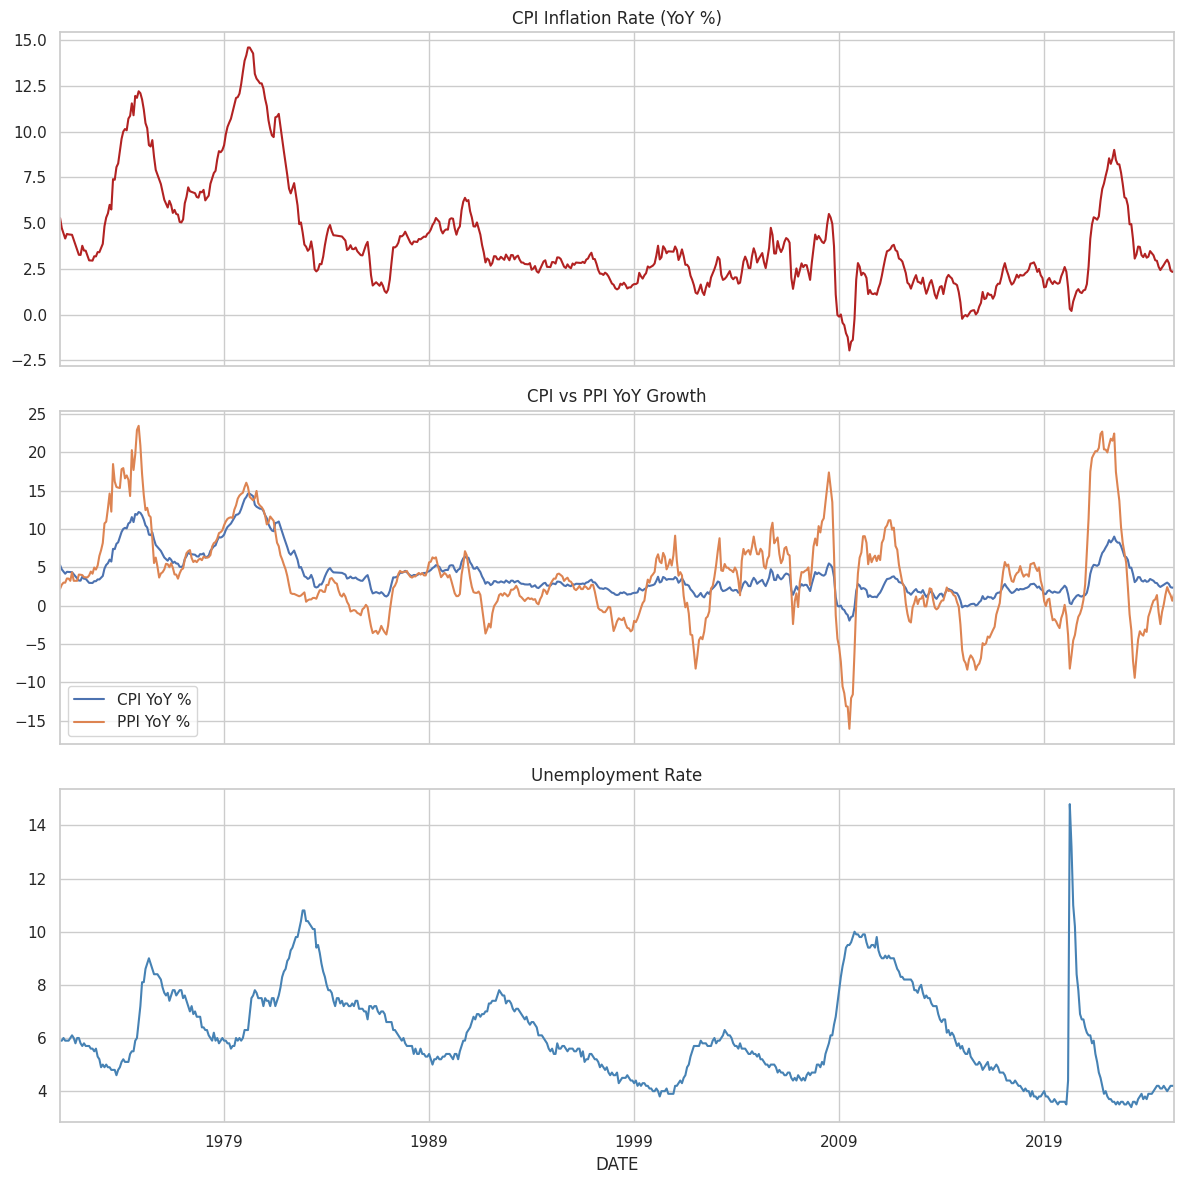

In [13]:

## 4-A Time-series plots
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
df["InflationRate"].plot(ax=ax[0], color="firebrick")
ax[0].set_title("CPI Inflation Rate (YoY %)")

df["CPI_yoy"].plot(ax=ax[1], label="CPI YoY %")
df["PPI_yoy"].plot(ax=ax[1], label="PPI YoY %")
ax[1].set_title("CPI vs PPI YoY Growth")
ax[1].legend()

df["UnempRate"].plot(ax=ax[2], color="steelblue")
ax[2].set_title("Unemployment Rate")
plt.tight_layout()
plt.show()

##  **Inflation-category distribution**

/tmp/ipython-input-14-673517962.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="InflationCategory",


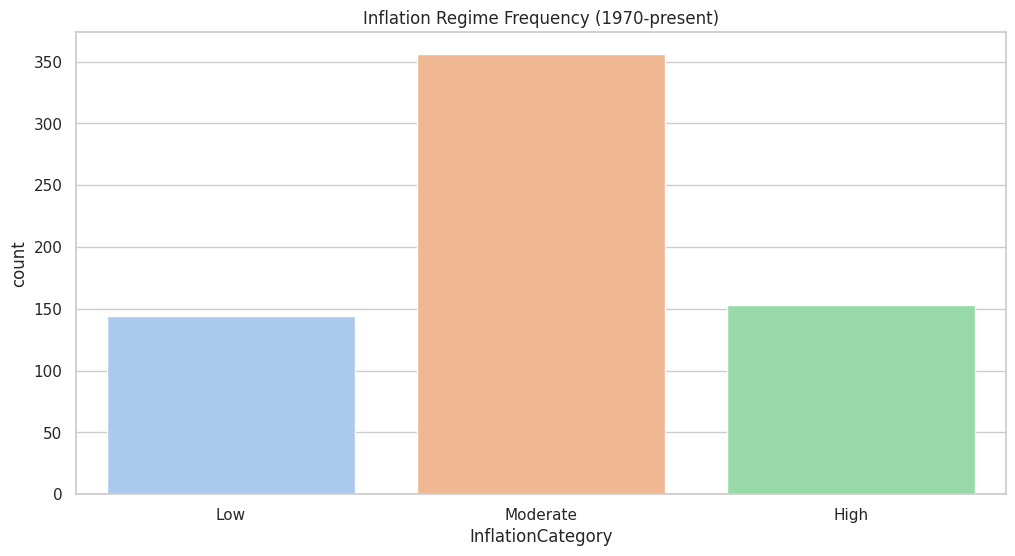

In [14]:


##  Inflation-category distribution
sns.countplot(data=df, x="InflationCategory",
              order=["Low", "Moderate", "High"],
              palette="pastel")
plt.title("Inflation Regime Frequency (1970-present)")
plt.show()

# **Correlation heat map**

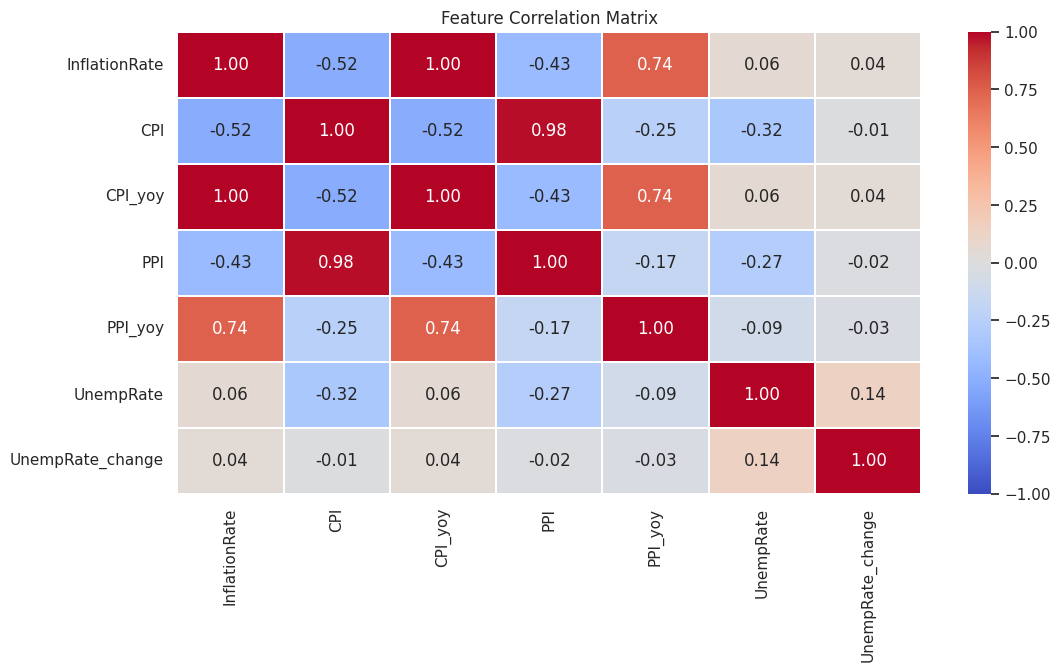

In [15]:


##  Correlation heat map
corr_mat = df.drop(columns="InflationCategory").corr()
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f",
            vmin=-1, vmax=1, linewidths=0.3)
plt.title("Feature Correlation Matrix")
plt.show()

## **Pairplot coloured by inflation regime**

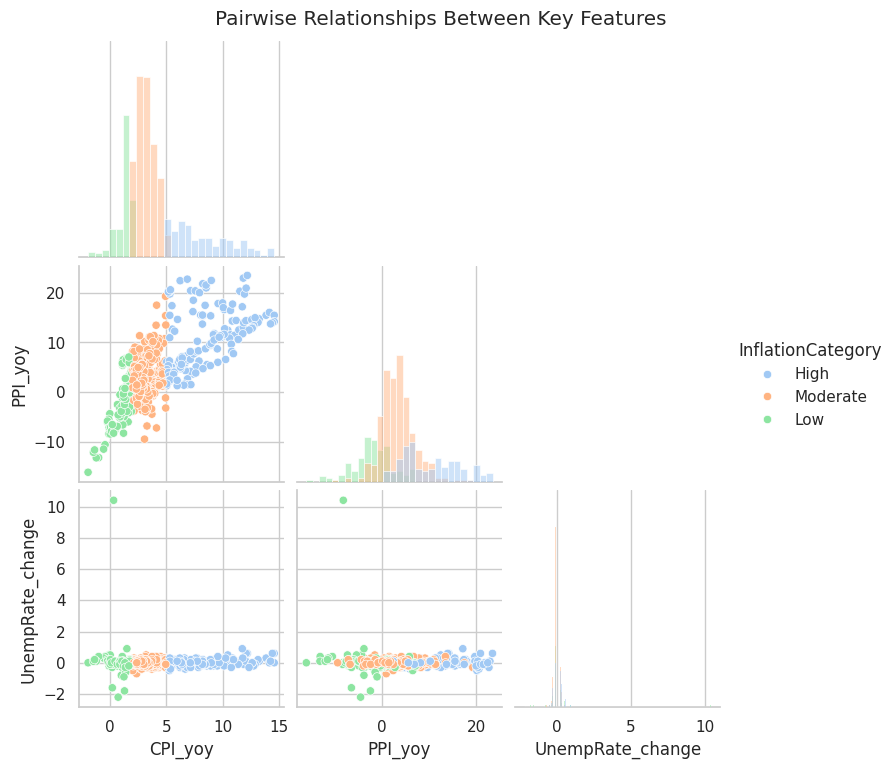

In [16]:

## Pairplot coloured by inflation regime
sns.pairplot(df[["CPI_yoy", "PPI_yoy", "UnempRate_change",
                 "InflationCategory"]],
             hue="InflationCategory", palette="pastel",
             corner=True, diag_kind="hist")
plt.suptitle("Pairwise Relationships Between Key Features", y=1.02)
plt.show()


## **Data Preparation for ML**

In [17]:
features = ["CPI_yoy", "PPI_yoy", "UnempRate_change",
            "CPI", "PPI", "UnempRate"]
X = df[features]
y = df["InflationCategory"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train shape:", X_train_s.shape, "  Test shape:", X_test_s.shape)


Train shape: (489, 6)   Test shape: (164, 6)


## **Model Training & Evaluation**

In [18]:
models = {
    "SVM"              : SVC(kernel='rbf', probability=True, random_state=42),
    "Neural Network"   : MLPClassifier(hidden_layer_sizes=(64,32),
                                       max_iter=500, early_stopping=True,
                                       random_state=42),
    "Random Forest"    : RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting" : GradientBoostingClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(multi_class='ovr', solver='liblinear',
                                             random_state=42)
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train_s, y_train)
    y_pred = mdl.predict(X_test_s)

    results[name] = {
        "Accuracy" : accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall"   : recall_score(y_test, y_pred, average='weighted'),
        "F1"       : f1_score(y_test, y_pred, average='weighted'),
        "CM"       : confusion_matrix(y_test, y_pred),
        "Report"   : classification_report(y_test, y_pred,
                                           target_names=le.classes_)
    }

pd.DataFrame(results).T[["Accuracy","Precision","Recall","F1"]]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,Accuracy,Precision,Recall,F1
SVM,0.884146,0.893154,0.884146,0.88198
Neural Network,0.878049,0.888312,0.878049,0.875825
Random Forest,0.993902,0.994055,0.993902,0.993924
GradientBoosting,1.0,1.0,1.0,1.0
LogisticRegression,0.896341,0.909905,0.896341,0.892443


##**Confusion Matrices & Performance Plots**

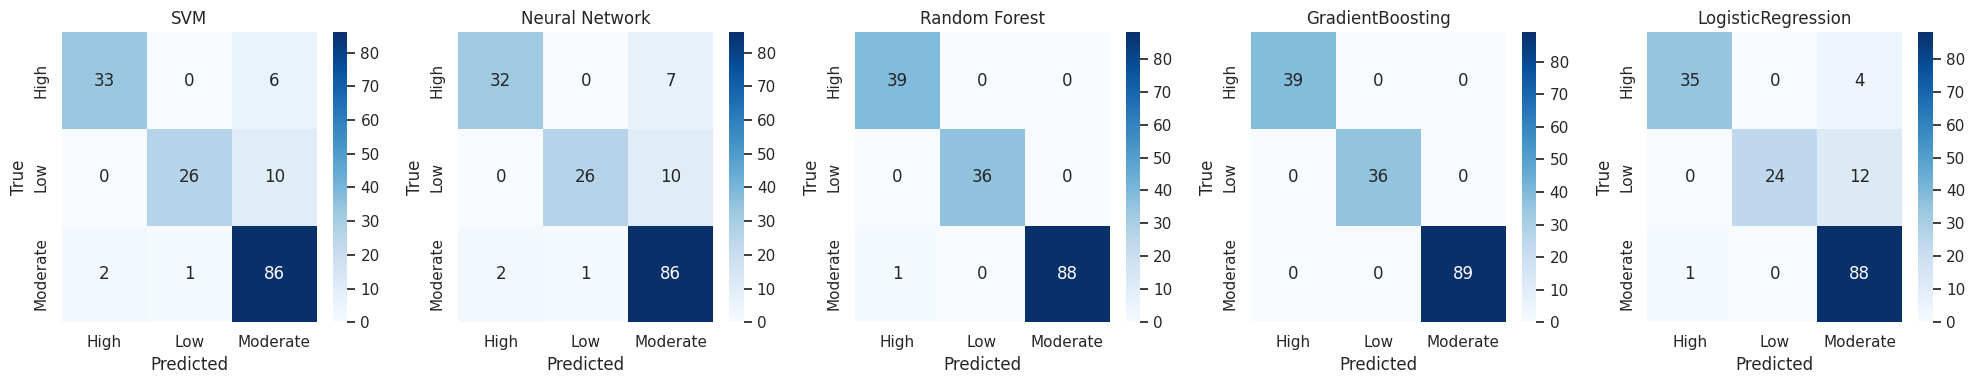

In [19]:
fig, axes = plt.subplots(1, len(models), figsize=(4*len(models), 4), squeeze=False)
axes = axes.ravel()

for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["CM"], annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title(name); ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout(); plt.show()

# **5-Fold Stratified Cross-Validation**

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

X_all_s = scaler.fit_transform(X)  # scale once for full set
for name, mdl in models.items():
    acc, f1 = [], []
    for train_idx, test_idx in kf.split(X_all_s, y_enc):
        X_tr, X_te = X_all_s[train_idx], X_all_s[test_idx]
        y_tr, y_te = y_enc[train_idx], y_enc[test_idx]

        m = mdl.__class__(**mdl.get_params())   # fresh clone
        m.fit(X_tr, y_tr)
        y_pr = m.predict(X_te)

        acc.append(accuracy_score(y_te, y_pr))
        f1.append(f1_score(y_te, y_pr, average='weighted'))

    cv_scores[name] = {"Acc CV mean": np.mean(acc), "Acc CV std": np.std(acc),
                       "F1 CV mean": np.mean(f1),  "F1 CV std": np.std(f1)}

pd.DataFrame(cv_scores).T

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

,Acc CV mean,Acc CV std,F1 CV mean,F1 CV std
SVM,0.921926,0.018855,0.921328,0.018957
Neural Network,0.799119,0.076651,0.786778,0.083061
Random Forest,0.998462,0.003077,0.998469,0.003063
GradientBoosting,1.000000,0.000000,1.000000,0.000000
LogisticRegression,0.911169,0.011521,0.908348,0.013174


# **t-tests**

In [22]:
# ================================================
# 🔁 Cell 7 – 5-Fold Stratified Cross-Validation
#         (stores per-fold scores for t-tests)
# ================================================
from collections import defaultdict

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_all_s = scaler.fit_transform(X)          # scale once on full data
y_all   = le.transform(y)

cv_raw   = defaultdict(lambda: {"Acc": [], "F1": []})   # per-fold lists
cv_stats = {}                                           # mean / std table

for name, mdl in models.items():
    for train_idx, test_idx in kf.split(X_all_s, y_all):
        X_tr, X_te = X_all_s[train_idx], X_all_s[test_idx]
        y_tr, y_te = y_all[train_idx],   y_all[test_idx]

        m = mdl.__class__(**mdl.get_params())           # clone
        m.fit(X_tr, y_tr)
        y_pr = m.predict(X_te)

        cv_raw[name]["Acc"].append(accuracy_score(y_te, y_pr))
        cv_raw[name]["F1" ].append(f1_score(y_te, y_pr, average='weighted'))

    cv_stats[name] = {
        "Acc μ": np.mean(cv_raw[name]["Acc"]),
        "Acc σ": np.std(cv_raw[name]["Acc"]),
        "F1 μ" : np.mean(cv_raw[name]["F1"]),
        "F1 σ" : np.std(cv_raw[name]["F1"]),
    }

pd.DataFrame(cv_stats).T


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

,Acc μ,Acc σ,F1 μ,F1 σ
SVM,0.921926,0.018855,0.921328,0.018957
Neural Network,0.799119,0.076651,0.786778,0.083061
Random Forest,0.998462,0.003077,0.998469,0.003063
GradientBoosting,1.000000,0.000000,1.000000,0.000000
LogisticRegression,0.911169,0.011521,0.908348,0.013174


In [ ]:

# ================================================================
# 3. Data Preparation for Machine Learning
# ================================================================

# Define features (X) and target (y)
features = ["CPI_yoy", "PPI_yoy", "UnempRate_change", "CPI", "PPI", "UnempRate"] # Including raw values as well
X = df[features]
y = df["InflationCategory"]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # Low: 0, Moderate: 1, High: 2

# Split data into training and testing sets
# Use stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nShape of training data (features):", X_train_scaled.shape)
print("Shape of testing data (features):", X_test_scaled.shape)
print("Shape of training data (target):", y_train.shape)
print("Shape of testing data (target):", y_test.shape)

# ================================================================
# 4. Model Training and Evaluation
# ================================================================

# Initialize multiple models
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42, early_stopping=True),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)
}

results = {}

print("\nTraining and Evaluating Models...")
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ConfusionMatrix": cm,
        "ClassificationReport": report
    }

    print(f"{name} Performance:")
    print(report)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)


# ================================================================
# 5. Compare Model Performance
# ================================================================
print("\n--- Model Performance Comparison ---")
performance_summary = pd.DataFrame({
    name: {metric: res[metric] for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]}
    for name, res in results.items()
}).T

print(performance_summary)

# Visualize Confusion Matrices
fig, axes = plt.subplots(1, len(models), figsize=(4 * len(models), 4))
axes = axes.flatten() if len(models) > 1 else [axes] # Ensure axes is iterable

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res["ConfusionMatrix"], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()


# ================================================================
# 6. Seasonality Testing (Conceptual - requires separate data prep)
# ================================================================
print("\n--- Seasonality Testing (Conceptual) ---")
print("To test seasonality, you would typically:")
print("1. Obtain or derive a seasonally adjusted version of the data.")
print("2. Train and evaluate the same models on the seasonally adjusted data.")
print("3. Compare performance metrics (Accuracy, F1-Score, etc.) between models trained on raw and seasonally adjusted data.")
print("\nExample structure for seasonally adjusted data testing:")

# # Conceptual code - requires 'df_sa' (seasonally adjusted dataframe)
# if 'df_sa' in locals(): # Check if seasonally adjusted data exists
#     X_sa = df_sa[features]
#     y_sa = df_sa["InflationCategory"]
#     y_sa_encoded = label_encoder.transform(y_sa) # Use the same encoder
#
#     X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(X_sa, y_sa_encoded, test_size=0.25, random_state=42, stratify=y_sa_encoded)
#     X_train_sa_scaled = scaler.fit_transform(X_train_sa) # Fit scaler again for SA data
#     X_test_sa_scaled = scaler.transform(X_test_sa)
#
#     sa_results = {}
#     for name, model in models.items(): # Re-initialize or clone models if state needs to be clean
#         model_sa = model.__class__(**model.get_params()) # Clone the model
#         print(f"\n--- Training {name} on Seasonally Adjusted Data ---")
#         model_sa.fit(X_train_sa_scaled, y_train_sa)
#         y_pred_sa = model_sa.predict(X_test_sa_scaled)
#
#         accuracy_sa = accuracy_score(y_test_sa, y_pred_sa)
#         f1_sa = f1_score(y_test_sa, y_pred_sa, average='weighted')
#         sa_results[name] = {"Accuracy_SA": accuracy_sa, "F1_SA": f1_sa}
#
#         print(f"{name} (SA Data) Performance:")
#         print(f"Accuracy_SA: {accuracy_sa:.4f}, F1_SA: {f1_sa:.4f}")
#
#     print("\n--- Performance Comparison (Raw vs. Seasonally Adjusted) ---")
#     sa_performance_summary = pd.DataFrame(sa_results).T
#     comparison_df = performance_summary[["Accuracy", "F1-Score"]].join(sa_performance_summary)
#     print(comparison_df)
# else:
#      print("Seasonally adjusted data ('df_sa') not available for testing.")


# ================================================================
# 7. Additional Tests / Insights
# ================================================================

# Statistical Significance Testing (Example: Comparing two models using McNemar's Test)
# McNemar's test is for comparing two classifiers on the same test set
# It's suitable for dependent samples (predictions from two models on the same data)
print("\n--- Statistical Significance Testing (Example: McNemar's Test) ---")

# Requires predictions from at least two models on the test set
# Let's compare SVM and Neural Network if available
if "SVM" in results and "NeuralNetwork" in results:
    y_pred_svm = models["SVM"].predict(X_test_scaled)
    y_pred_nn = models["NeuralNetwork"].predict(X_test_scaled)

    # Create contingency table for McNemar's test
    # a: Both correct, b: Model1 wrong, Model2 correct, c: Model1 correct, Model2 wrong, d: Both wrong
    # McNemar's is typically for binary classification or pairwise comparison in multi-class
    # We can simplify to correct vs incorrect for each model
    svm_correct = (y_pred_svm == y_test)
    nn_correct = (y_pred_nn == y_test)

    # Cells of the 2x2 table:
    # A: Both correct
    # B: SVM wrong, NN correct
    # C: SVM correct, NN wrong
    # D: Both wrong
    n_both_correct = np.sum(svm_correct & nn_correct)
    n_svm_wrong_nn_correct = np.sum(~svm_correct & nn_correct)
    n_svm_correct_nn_wrong = np.sum(svm_correct & ~nn_correct)
    n_both_wrong = np.sum(~svm_correct & ~nn_correct)

    contingency_table = [[n_both_correct, n_svm_correct_nn_wrong],
                         [n_svm_wrong_nn_correct, n_both_wrong]]

    print("\nContingency table (SVM vs Neural Network):")
    print("               Neural Network")
    print("              Correct   Incorrect")
    print(f"       Correct  {contingency_table[0][0]:<7}   {contingency_table[0][1]}")
    print(f"SVM    Incorrect{contingency_table[1][0]:<7}   {contingency_table[1][1]}")


    try:
        # Perform McNemar's test
        # The test compares the counts in the off-diagonal cells (b and c)
        from statsmodels.stats.contingency_tables import mcnemar
        result = mcnemar(contingency_table, exact=False) # exact=False uses chi-squared approx

        print("\nMcNemar's Test (SVM vs Neural Network):")
        print(f"Statistic: {result.statistic:.4f}")
        print(f"p-value: {result.pvalue:.4f}")

        alpha = 0.05
        if result.pvalue < alpha:
            print(f"Conclusion: Reject the null hypothesis. There is a statistically significant difference in the performance of SVM and Neural Network ({alpha*100:.0f}% significance level).")
        else:
            print(f"Conclusion: Fail to reject the null hypothesis. There is no statistically significant difference in the performance of SVM and Neural Network ({alpha*100:.0f}% significance level).")

    except ImportError:
        print("Please install statsmodels for McNemar's test: !pip install statsmodels")
    except Exception as e:
         print(f"Could not perform McNemar's test: {e}")

else:
    print("Need predictions from at least two models to perform McNemar's Test.")


# Cross-validation performance (More robust evaluation)
print("\n--- Cross-Validation Performance ---")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Using Stratified KFold

cv_results = {}

for name, model in models.items():
    print(f"\nRunning {kf.get_n_splits()} fold cross-validation for {name}...")
    # Need to scale data within each fold for a proper CV pipeline,
    # but for simplicity here, we'll use the already scaled full data
    # A proper pipeline would involve sklearn's Pipeline
    X_full_scaled = scaler.fit_transform(X)
    y_full_encoded = label_encoder.transform(y)

    accuracy_scores = []
    f1_scores = [] # Weighted F1

    for fold, (train_index, test_index) in enumerate(kf.split(X_full_scaled, y_full_encoded)):
        X_train_fold, X_test_fold = X_full_scaled[train_index], X_full_scaled[test_index]
        y_train_fold, y_test_fold = y_full_encoded[train_index], y_full_encoded[test_index]

        model_fold = model.__class__(**model.get_params()) # Clone the model
        model_fold.fit(X_train_fold, y_train_fold)
        y_pred_fold = model_fold.predict(X_test_fold)

        accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
        f1_scores.append(f1_score(y_test_fold, y_pred_fold, average='weighted'))
        # print(f"  Fold {fold+1}: Accuracy={accuracy_scores[-1]:.4f}, F1={f1_scores[-1]:.4f}")


    cv_results[name] = {
        "Avg Accuracy (CV)": np.mean(accuracy_scores),
        "Std Accuracy (CV)": np.std(accuracy_scores),
        "Avg F1-Score (CV)": np.mean(f1_scores),
        "Std F1-Score (CV)": np.std(f1_scores)
    }
    print(f"{name}: Avg Accuracy={cv_results[name]['Avg Accuracy (CV)']:.4f} (+/- {cv_results[name]['Std Accuracy (CV)']:.4f}), Avg F1={cv_results[name]['Avg F1-Score (CV)']:.4f} (+/- {cv_results[name]['Std F1-Score (CV)']:.4f})")

cv_performance_summary = pd.DataFrame(cv_results).T
print("\n--- Cross-Validation Performance Summary ---")
cv_performance_summary

